In [1]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

import scipy
import csv
import networkx as nx

import statsmodels.stats.multitest as multitest

picklepath = ''

met_all = pd.read_pickle(picklepath+'met_all.pickle')

pro_all = pd.read_pickle(picklepath+'pro_all.pickle')

pro_all_clean_names = pro_all
pro_all_clean_names.columns = [name.split(' ')[0] for name in pro_all_clean_names.columns.values.tolist()]

shap_dict =  pickle.load( open( picklepath+"shap_pmet_all.pickle", "rb" ) )
shap_values=np.asarray(list(shap_dict.values()))
met_all_names = met_all.columns.values.tolist()

pro_all_clean_names_resp = pro_all_clean_names.filter(like='resp', axis=0)
pro_all_clean_names_ferm = pro_all_clean_names.filter(like='ferm', axis=0)

proalllist = pro_all_clean_names.values.tolist()
proalllistnames = pro_all_clean_names.columns.tolist()

proallresplist = pro_all_clean_names_resp.values.tolist()
proallresplistnames = pro_all_clean_names_resp.columns.tolist()

proallfermlist = pro_all_clean_names_ferm.values.tolist()
proallfermlistnames = pro_all_clean_names_ferm.columns.tolist()

In [2]:
proallresplistarray = []
i = 0
j = 0

while i < len(proallresplist):
    j=0
    while j < len(proallresplist[i]):
        if len(proallresplistarray)<len(proallresplist[0]):
            proallresplistarray.append([])
        proallresplistarray[j].append(proallresplist[i][j])
        j+=1
    i+=1

In [3]:
proallfermlistarray = []
i = 0
j = 0

while i < len(proallfermlist):
    j=0
    while j < len(proallfermlist[i]):
        if len(proallfermlistarray)<len(proallfermlist[0]):
            proallfermlistarray.append([])
        proallfermlistarray[j].append(proallfermlist[i][j])
        j+=1
    i+=1

# Find the spearman correlation
Finds spearman correlation between each protein across all samples split by fermentation and respiration conditions
Adjusts p-value by Bonferroni correction

In [ ]:

#protein correlation all resp

i = 0
j = 0
k = 0

correlationarray = []
j=0
while j<len(proallresplistarray):
    k=0
    print(j/len(proallresplistarray), end='\r')
    while k<len(proallresplistarray):
        r, p = scipy.stats.spearmanr(proallresplistarray[j], proallresplistarray[k])
        
        correlationarray.append([proallresplistnames[j], proallresplistnames[k], p, r])
        #print(k/len(shap_values_arrays[i]))
        k+=1

    
    j+=1
    
df = pd.DataFrame(correlationarray, columns =['Protein 1', 'Protein2', "pValue", "rho"])


i+=1


bonferroni = multitest.multipletests(df['pValue'].tolist(), alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
bh = multitest.multipletests(df['pValue'].tolist(), alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
df.insert(2, "bonferroni", bonferroni[1])
df.insert(2, "bh", bh[1])
df.to_csv("pro_all_resp_corr_adj.csv", sep=',',index=False)




#protein correlation all ferm

i = 0
j = 0
k = 0

correlationarray = []
j=0
while j<len(proallfermlistarray):
    k=0
    print(j/len(proallfermlistarray), end='\r')
    while k<len(proallfermlistarray):
        r, p = scipy.stats.spearmanr(proallfermlistarray[j], proallfermlistarray[k])
        
        correlationarray.append([proallfermlistnames[j], proallfermlistnames[k], p, r])
        #print(k/len(shap_values_arrays[i]))
        k+=1

    
    j+=1
    
df = pd.DataFrame(correlationarray, columns =['Protein 1', 'Protein2', "pValue", "rho"])


i+=1

bonferroni = multitest.multipletests(df['pValue'].tolist(), alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
bh = multitest.multipletests(df['pValue'].tolist(), alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
df.insert(2, "bonferroni", bonferroni[1])
df.insert(2, "bh", bh[1])
df.to_csv("pro_all_ferm_corr_adj.csv", sep=',',index=False)
dfbonferroni = df

In [ ]:
dfbonferronirho = dfbonferroni.loc[abs(dfbonferroni["rho"]) > 0.7]
dfbonferronirho

In [ ]:
dfbonferronirho.to_csv("pro_all_ferm_corr_adj_bonferronirho.csv", sep=',',index=False)

In [ ]:
dfbonferronirho= pd.read_csv("pro_all_ferm_corr_adj_bonferronirho.csv", sep=',')

In [ ]:
protein1 = dfbonferronirho["Protein 1"].tolist()
protein2 = dfbonferronirho["Protein2"].tolist()
rho = dfbonferronirho["rho"].tolist()

In [ ]:
shap_dict =  pickle.load( open( picklepath+"shap_pmet_all.pickle", "rb" ) )
shap_values=np.asarray(list(shap_dict.values()))


# Get sign of each protein fold change, multiply shap value by sign
Ensure shap values are comparable to protein fold changes, i.e. positive shap due to negative fold change is negative

In [ ]:
len(pro_all_clean_names.to_numpy()[0])

signs = []

i = 0
while i < len(pro_all_clean_names.to_numpy()):
    temp = []
    j = 0
    while j < len(pro_all_clean_names.to_numpy()[0]):
        if pro_all_clean_names.to_numpy()[i][j]<0:
            temp.append(-1)
        else:
            temp.append(1)
        j+=1
    signs.append(temp)
    i+=1

In [ ]:
shap_values_signs = []
k = 0
while k < len(shap_values):
    temp1 = []
    i = 0
    while i < len(signs):
        temp = []
        j = 0
        while j < len(signs[0]):
            temp.append(signs[i][j]*shap_values[k][i][j])
            j+=1
        temp1.append(temp)
        i+=1
    shap_values_signs.append(temp1)
    k+=1
    
shap_values_signs = np.array(shap_values_signs)

In [ ]:
pickle.dump( shap_values_signs, open( "shap_values_met_all_signs.pickle", "wb" ) )

In [12]:
shap_values_signs = pickle.load(open( picklepath+"shap_values_met_all_signs.pickle", "rb" ))

In [13]:
shap_values = shap_values_signs
#shap_values = abs(np.array(shap_values)).mean(axis=1)
shap_values = np.array(shap_values).mean(axis=1)

In [ ]:
pickle.dump( shap_values, open( "shap_values_met_all_mean_signs.pickle", "wb" ) )

In [14]:
citrateshapdf = pd.DataFrame(zip(list(pro_all_clean_names.columns), shap_values[20], abs(shap_values[20])), columns = ["name" , "shap", "magnitude"])

In [15]:


##Connections with shap and correlated proteins
citrateshapdf = citrateshapdf.sort_values(by = 'magnitude', ascending = False)
sortednames = citrateshapdf["name"].tolist()
sortedshap = citrateshapdf["shap"].tolist()

sortednames = sortednames[0:20]
sortedshap = sortedshap[0:20]

G = nx.Graph()
G.add_node("Citric Acid")
i = 0
while i < len(sortednames):
    G.add_node(sortednames[i])
    G.add_edge("Citric Acid", sortednames[i], shap = float(sortedshap[i]), rho = float(0.0))
    j = 0
    while j < len(protein1):
        if protein1[j] == sortednames[i]:
            if (rho[j] > 0.7 or rho[j] < -0.7):
                G.add_node(protein2[j])
                G.add_edge(sortednames[i], protein2[j], shap = float(0.0)  , rho = float(rho[j]))

        j+=1
    i+=1


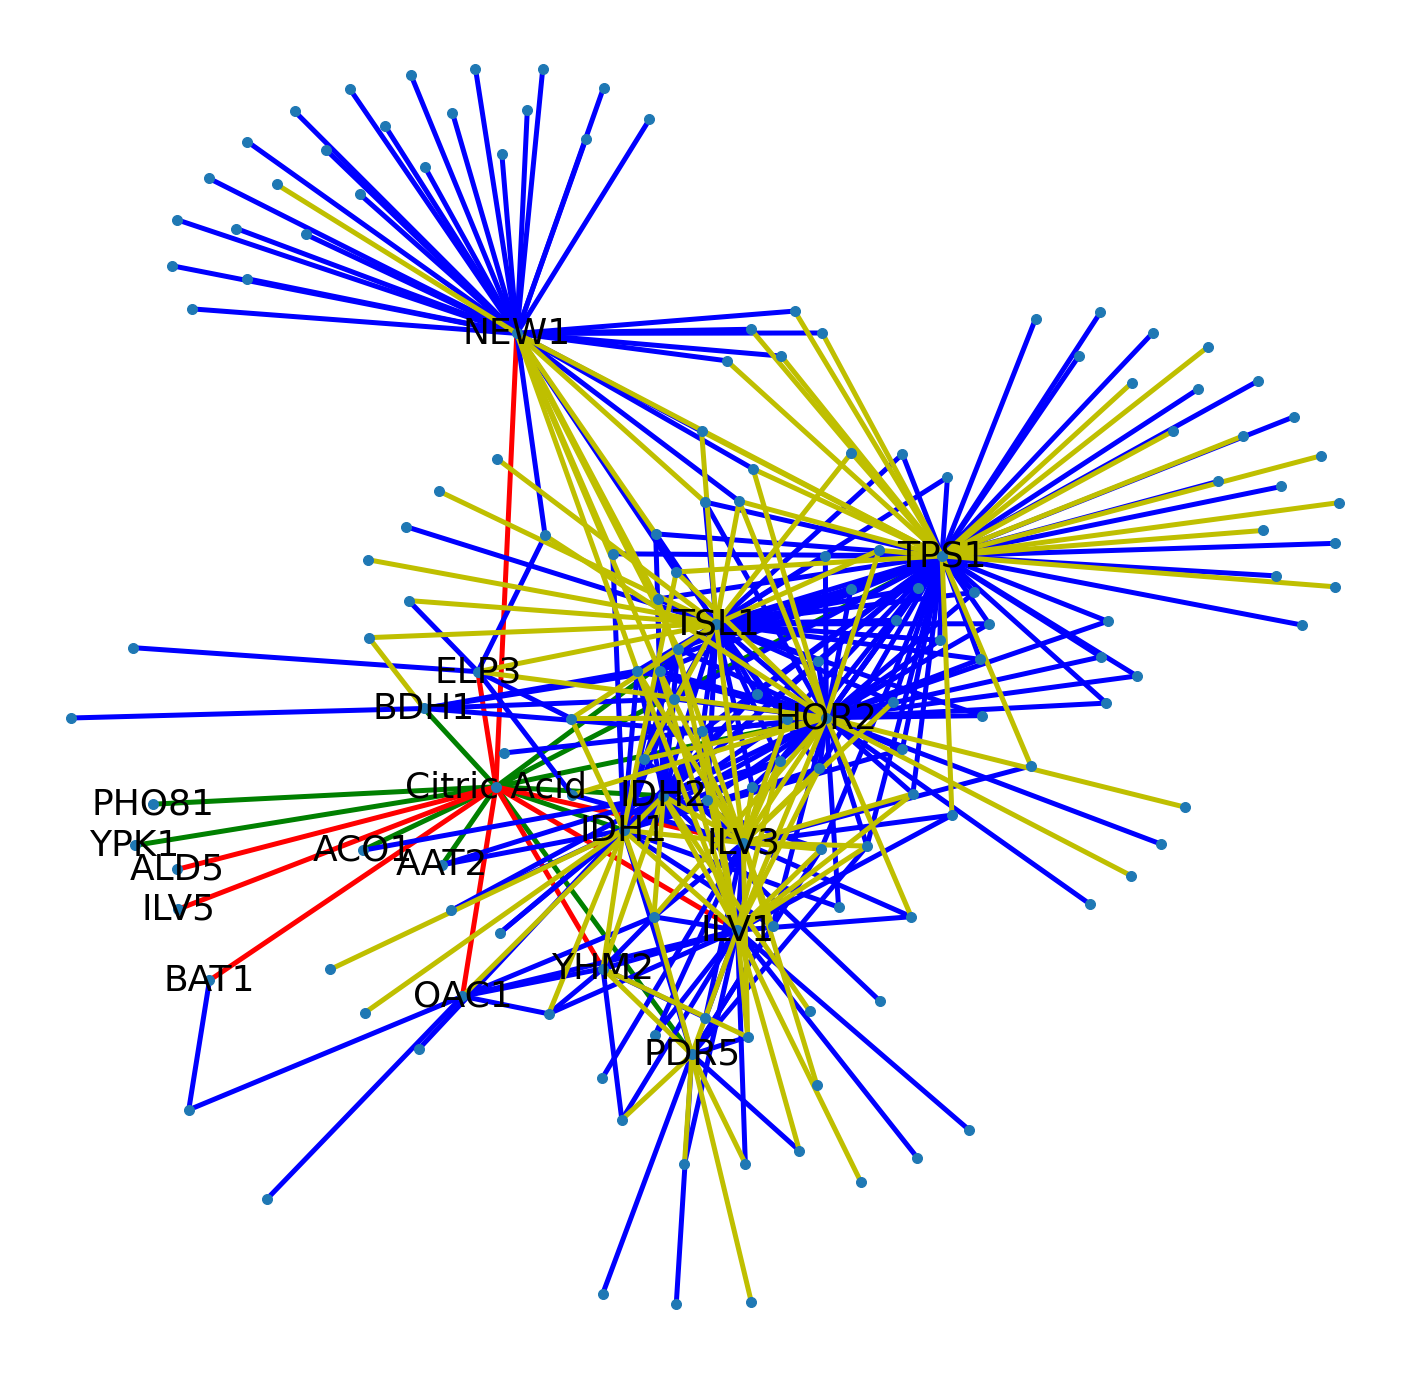

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
labelsdict = {}


pos = nx.spring_layout(G, k = 10, iterations = 5000)
shappos = [(u, v) for (u, v, d) in G.edges(data=True) if d["shap"] > 0]
shapneg = [(u, v) for (u, v, d) in G.edges(data=True) if d["shap"] < 0]
corr = [(u, v) for (u, v, d) in G.edges(data=True) if d["rho"] > 0.7]
anticorr = [(u, v) for (u, v, d) in G.edges(data=True) if d["rho"] < -0.7]

#pos = nx.spring_layout(G, k = 10, iterations = 100)  # positions for all nodes
#pos = nx.spring_layout(G,k=1, iterations = 100, pos = {"Fumaric Acid" : [5,-5], "Citric Acid" : [-5,-5], "2-Ketoglutaric Acid" : [5, 5]}, fixed = ["Fumaric Acid", "Citric Acid",  "2-Ketoglutaric Acid"])  # positions for all nodes
plt.figure(figsize=(25,25)) 
# nodes
nx.draw_networkx_nodes(G, pos, node_size=100)

# edges
nx.draw_networkx_edges(G, pos, edgelist=shappos, edge_color="g", width=5)
nx.draw_networkx_edges(G, pos, edgelist=shapneg, edge_color="r", width=5)
nx.draw_networkx_edges(G, pos, edgelist=corr, edge_color="b", width=5)
nx.draw_networkx_edges(G, pos, edgelist=anticorr, edge_color="y", width=5)

i = 0
while i < len(sortednames):
    labelsdict[sortednames[i]] = sortednames[i]
    i+=1
labelsdict["Citric Acid"] = "Citric Acid"
    
    
# labels
nx.draw_networkx_labels(G, pos, labels=labelsdict, font_size=36, font_family="sans-serif")

plt.axis("off")
plt.savefig("plot2-citric-posshaps.svg")
plt.show()

In [ ]:
nx.write_graphml(G,"citrate_corr.xml")